# Identifying CyberSecurity Threats

## Loading Libraries and Data

In [113]:
#importing basic packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats



In [114]:
#loading the data
df_train = pd.read_csv('cyber/UNSW_NB15_training-set.csv')
df_test = pd.read_csv('cyber/UNSW_NB15_testing-set.csv')

In [115]:
df_train.info()  # Get basic info about the dataset
df_train.describe()  # Get summary statistics of numerical columns
df_train.head()  # Check the first few rows of the dataset


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 175341 non-null  int64  
 1   dur                175341 non-null  float64
 2   proto              175341 non-null  object 
 3   service            175341 non-null  object 
 4   state              175341 non-null  object 
 5   spkts              175341 non-null  int64  
 6   dpkts              175341 non-null  int64  
 7   sbytes             175341 non-null  int64  
 8   dbytes             175341 non-null  int64  
 9   rate               175341 non-null  float64
 10  sttl               175341 non-null  int64  
 11  dttl               175341 non-null  int64  
 12  sload              175341 non-null  float64
 13  dload              175341 non-null  float64
 14  sloss              175341 non-null  int64  
 15  dloss              175341 non-null  int64  
 16  si

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


## Data Exploration and Preprocessing

In [116]:

# Check for missing values
missing_values = df_train.isnull().sum()
print("Missing values in each column:\n", missing_values)


Missing values in each column:
 id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is

In [117]:
# Check class distribution (Benign vs Attack)
print("Label distribution:\n", df_train['label'].value_counts())


Label distribution:
 label
1    119341
0     56000
Name: count, dtype: int64


In [118]:
# Distribution of attack categories
print(df_train['attack_cat'].value_counts(normalize=True))



attack_cat
Normal            0.319378
Generic           0.228127
Exploits          0.190446
Fuzzers           0.103706
DoS               0.069944
Reconnaissance    0.059832
Analysis          0.011406
Backdoor          0.009958
Shellcode         0.006462
Worms             0.000741
Name: proportion, dtype: float64


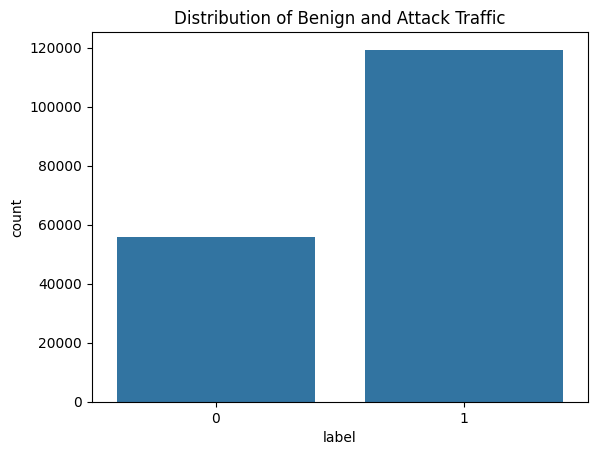

In [119]:
# Visualize class distribution (Benign vs Attack)
sns.countplot(x='label', data=df_train)
plt.title('Distribution of Benign and Attack Traffic')
plt.show()

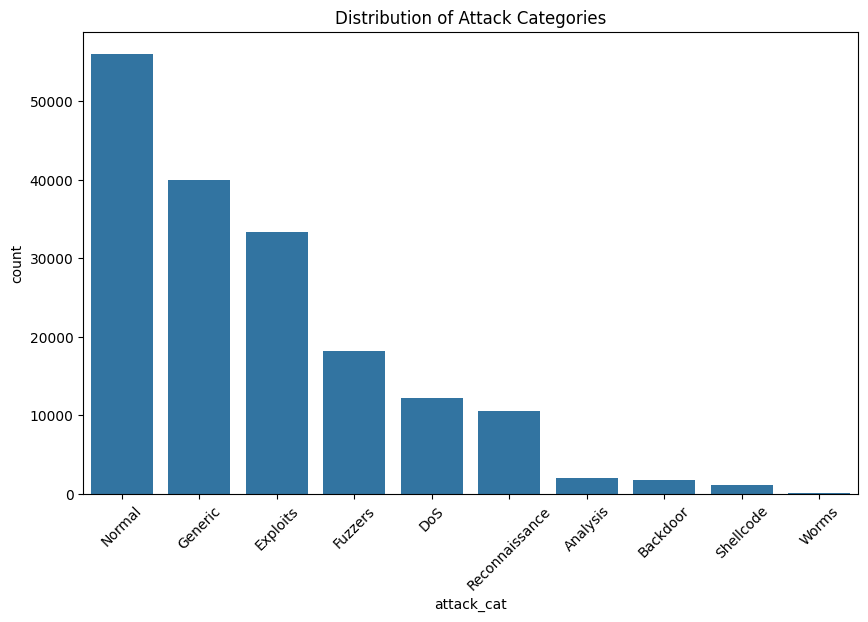

In [120]:
# Visualize the distribution of attack categories
plt.figure(figsize=(10, 6))
sns.countplot(x='attack_cat', data=df_train, order=df_train['attack_cat'].value_counts().index)
plt.title('Distribution of Attack Categories')
plt.xticks(rotation=45)
plt.show()


In [121]:
# Identify and handle categorical features (proto, service, state, attack_cat)
categorical_columns = ['proto', 'service', 'state', 'attack_cat']

# Convert categorical columns to numerical using Label Encoding
le = LabelEncoder()
for col in categorical_columns:
    df_train[col] = le.fit_transform(df_train[col])



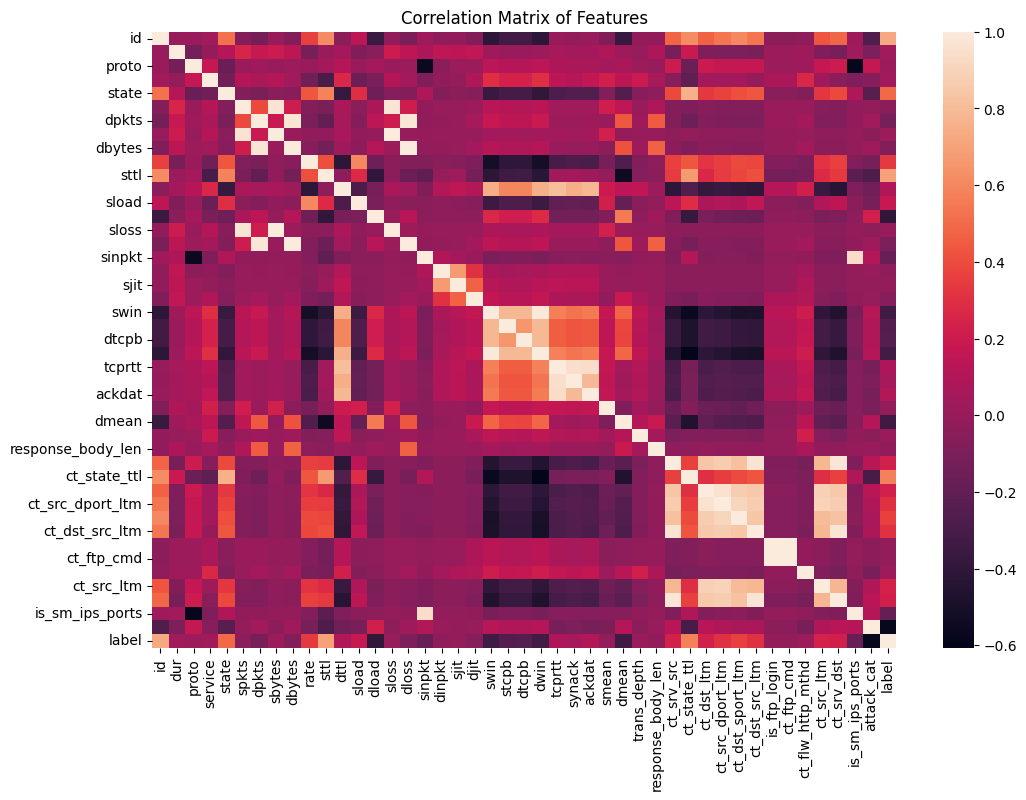

In [122]:
# Check the correlation matrix to identify highly correlated features
corr_matrix = df_train.corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False)
plt.title('Correlation Matrix of Features')
plt.show()


In [123]:
## Data Preprocessing

# Separate features and target
X = df_train.drop(['label','id'], axis=1)
y = df_train['label']


### Feature Engineering

Ratio features: These capture the relationship between source and destination for bytes, packets, and load.
Statistical features: We calculate mean and standard deviation for bytes and packets, which can help identify unusual patterns.
Binning: We create categories for the duration feature, which can help capture non-linear effects.
Frequency encoding: For categorical variables, we replace categories with their frequency, which can be useful for high-cardinality features.
Aggregated features: We create sum and average features for bytes and packets.
Domain-specific features: Based on cybersecurity knowledge, we create binary flags for specific services and port ranges.
Interaction terms: We multiply related features to capture their combined effect.
Percentile-based features: These can help capture the relative magnitude of a feature value.
Entropy-based features: For byte-related columns, we calculate Shannon entropy, which can be useful for detecting certain types of attacks.

In [124]:
# 1. Ratio features
X['bytes_ratio'] = X['sbytes'] / (X['dbytes'] + 1)  # Adding 1 to avoid division by zero
X['packets_ratio'] = X['spkts'] / (X['dpkts'] + 1)
X['load_ratio'] = X['sload'] / (X['dload'] + 1)

# 2. Statistical features
numeric_cols = X.select_dtypes(include=[np.number]).columns
X['mean_bytes'] = X[['sbytes', 'dbytes']].mean(axis=1)
X['std_bytes'] = X[['sbytes', 'dbytes']].std(axis=1)
X['mean_packets'] = X[['spkts', 'dpkts']].mean(axis=1)
X['std_packets'] = X[['spkts', 'dpkts']].std(axis=1)

# 3. Binning
X['dur_bin'] = pd.qcut(X['dur'], q=5, labels=['very_short', 'short', 'medium', 'long', 'very_long'])
le_dur_bin = LabelEncoder()
X['dur_bin'] = le_dur_bin.fit_transform(X['dur_bin'])



# 4. Aggregated features
X['total_bytes'] = X['sbytes'] + X['dbytes']
X['total_packets'] = X['spkts'] + X['dpkts']
X['avg_packet_size'] = X['total_bytes'] / (X['total_packets'] + 1)

# 5. Interaction terms
X['sttl_dttl_interaction'] = X['sttl'] * X['dttl']
X['sload_dload_interaction'] = X['sload'] * X['dload']

In [125]:
# 6. Frequency encoding for categorical variables
for col in ['proto', 'service', 'state']:
    freq_enc = X[col].value_counts(normalize=True)
    X[f'{col}_freq'] = X[col].map(freq_enc)



# 7. Time window features (assuming 'dur' is in seconds)
X['is_long_connection'] = (X['dur'] > 3600).astype(int)  # Connections longer than an hour

In [126]:
correlation_matrix = X.corr()

top_corr_pairs = correlation_matrix.unstack().sort_values(ascending=False).drop_duplicates()
top_corr_pairs = top_corr_pairs[top_corr_pairs != 1.0]  # Remove self-correlations

for (feat1, feat2), corr_value in top_corr_pairs.head(5).items():
    X[f'{feat1}_{feat2}_interaction'] = X[feat1] * X[feat2]



In [127]:


# 8. Entropy-based features (for byte-related columns) - creating shanon entropy
def calculate_entropy(data):
    _, counts = np.unique(data, return_counts=True)
    return stats.entropy(counts)

X['sbytes_entropy'] = X['sbytes'].apply(calculate_entropy)
X['dbytes_entropy'] = X['dbytes'].apply(calculate_entropy)


### Feature Selection

In [128]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [130]:
# 1. Correlation-based Feature Selection
def correlation_feature_selection(X, threshold=0.8):
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return X.drop(to_drop, axis=1)

X_uncorrelated = correlation_feature_selection(X_train)
print("Features after correlation-based selection:", X_uncorrelated.columns)


Features after correlation-based selection: Index(['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'rate', 'sttl',
       'dttl', 'sload', 'dload', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin',
       'stcpb', 'dtcpb', 'smean', 'dmean', 'trans_depth', 'response_body_len',
       'ct_srv_src', 'ct_state_ttl', 'is_ftp_login', 'ct_flw_http_mthd',
       'attack_cat', 'bytes_ratio', 'dur_bin', 'avg_packet_size', 'proto_freq',
       'state_freq', 'is_long_connection', 'load_ratio_sload_interaction',
       'dbytes_dloss_interaction', 'sbytes_entropy', 'dbytes_entropy'],
      dtype='object')


In [131]:
# 2. Univariate Feature Selection
k_best_f = SelectKBest(f_classif, k=20)
k_best_f.fit(X_train, y_train)
X_k_best_f = X_train.iloc[:, k_best_f.get_support()]
print("Top features by F-score:", X_k_best_f.columns)

k_best_mi = SelectKBest(mutual_info_classif, k=20)
k_best_mi.fit(X_train, y_train)
X_k_best_mi = X_train.iloc[:, k_best_mi.get_support()]
print("Top features by Mutual Information:", X_k_best_mi.columns)

d:\MLDL Projects\vproj\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [59 65 66] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
d:\MLDL Projects\vproj\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Top features by F-score: Index(['state', 'rate', 'sttl', 'dload', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'dmean', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm',
       'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'ct_src_ltm', 'attack_cat',
       'dur_bin', 'sload_dload_interaction', 'proto_freq', 'state_freq'],
      dtype='object')
Top features by Mutual Information: Index(['dur', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'smean',
       'ct_state_ttl', 'attack_cat', 'bytes_ratio', 'packets_ratio',
       'load_ratio', 'mean_bytes', 'std_bytes', 'total_bytes',
       'avg_packet_size', 'sttl_dttl_interaction',
       'std_bytes_mean_bytes_interaction',
       'total_bytes_std_bytes_interaction'],
      dtype='object')


In [132]:
# 3. L1-based Feature Selection (Lasso)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
lasso = Lasso(alpha=0.01)
lasso.fit(X_scaled, y_train)
lasso_selected = X_train.columns[abs(lasso.coef_) > 0]
print("Features selected by Lasso:", lasso_selected)

Features selected by Lasso: Index(['sttl', 'dttl', 'swin', 'synack', 'smean', 'ct_state_ttl',
       'ct_dst_sport_ltm', 'is_sm_ips_ports', 'attack_cat', 'dur_bin',
       'service_freq', 'state_freq'],
      dtype='object')


In [133]:
# 4. Recursive Feature Elimination (RFE)
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=20, step=1)
rfe_selector = rfe_selector.fit(X_train, y_train)
rfe_selected = X_train.columns[rfe_selector.support_]
print("Features selected by RFE:", rfe_selected)


Features selected by RFE: Index(['sbytes', 'dbytes', 'rate', 'sload', 'dload', 'sinpkt', 'sjit', 'stcpb',
       'dtcpb', 'load_ratio', 'mean_bytes', 'std_bytes', 'total_bytes',
       'sttl_dttl_interaction', 'sload_dload_interaction',
       'load_ratio_sload_interaction', 'std_bytes_mean_bytes_interaction',
       'total_bytes_std_bytes_interaction', 'dbytes_dloss_interaction',
       'sbytes_sloss_interaction'],
      dtype='object')


In [134]:
# Ensemble Feature Selection
def ensemble_feature_selection(feature_lists, threshold=0.5):
    feature_votes = {}
    for features in feature_lists:
        for feature in features:
            if feature in feature_votes:
                feature_votes[feature] += 1
            else:
                feature_votes[feature] = 1
    
    n_methods = len(feature_lists)
    selected_features = [f for f, votes in feature_votes.items() if votes / n_methods >= threshold]
    return selected_features

all_selected_features = [
    X_uncorrelated.columns,
    X_k_best_f.columns,
    X_k_best_mi.columns,
    lasso_selected,
    rfe_selected,
]

ensemble_selected = ensemble_feature_selection(all_selected_features)
print("Features selected by Ensemble method:", ensemble_selected)

# Final selected features
X_selected = X_train[ensemble_selected]
print("Shape of dataset after feature selection:", X_selected.shape)
print(X_selected.head())

Features selected by Ensemble method: ['rate', 'sttl', 'dttl', 'sload', 'dload', 'swin', 'stcpb', 'dtcpb', 'smean', 'ct_state_ttl', 'attack_cat', 'dur_bin', 'state_freq']
Shape of dataset after feature selection: (140272, 13)
                 rate  sttl  dttl         sload         dload  swin  \
96203       32.806626    62   252  1.103846e+04  15654.549810   255   
58960   111111.107200   254     0  8.888889e+07      0.000000     0   
65069       31.555592   254   252  4.990571e+04   5414.504395   255   
64133       18.937147    62   252  5.469845e+03  30283.488280   255   
111445  200000.005100   254     0  1.600000e+08      0.000000     0   

             stcpb       dtcpb  smean  ct_state_ttl  attack_cat  dur_bin  \
96203   3478197162  2470759746     79             1           6        0   
58960            0           0    100             2           0        2   
65069   1170662925  3121192582    337             1           6        3   
64133    338263265  1306255349     76      

## Modelling

In [135]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import time

In [136]:
# Assuming X_selected is your feature matrix and y is your target variable after feature selection
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


ValueError: Found input variables with inconsistent numbers of samples: [140272, 175341]

In [ ]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True),
    'Naive Bayes': GaussianNB(),
    'Neural Network': MLPClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
}


In [ ]:
# Function to evaluate model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    start_time = time.time()
    y_pred = model.predict(X_test)
    predict_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    cv_mean = np.mean(cv_scores)
    cv_std = np.std(cv_scores)
    
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'CV Mean': cv_mean,
        'CV Std': cv_std,
        'Train Time': train_time,
        'Predict Time': predict_time
    }


In [ ]:
# Evaluate all models
results = {}
for name, model in models.items():
    print(f"Evaluating {name}...")
    results[name] = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test)


In [ ]:
# Create results dataframe
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('F1 Score', ascending=False)

# Format the results
results_df['Accuracy'] = results_df['Accuracy'].map('{:.4f}'.format)
results_df['Precision'] = results_df['Precision'].map('{:.4f}'.format)
results_df['Recall'] = results_df['Recall'].map('{:.4f}'.format)
results_df['F1 Score'] = results_df['F1 Score'].map('{:.4f}'.format)
results_df['ROC AUC'] = results_df['ROC AUC'].map('{:.4f}'.format)
results_df['CV Mean'] = results_df['CV Mean'].map('{:.4f}'.format)
results_df['CV Std'] = results_df['CV Std'].map('{:.4f}'.format)
results_df['Train Time'] = results_df['Train Time'].map('{:.2f} s'.format)
results_df['Predict Time'] = results_df['Predict Time'].map('{:.4f} s'.format)

# Display results
print(results_df)


In [ ]:
# Get the best model
best_model_name = results_df.index[0]
best_model = models[best_model_name]

# Confusion Matrix for the best model
y_pred = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix for {best_model_name}:")
print(cm)


## Evaluation

# Prepare the test data
X_test = df_test[X_selected.columns]
y_test = df_test['label']  # Assuming 'label' is the target column



In [ ]:
# Scale the features
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)



In [ ]:
# Make predictions
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]


In [ ]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print results
print("Model Performance on Test Data:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")



In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [ ]:
# ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

